 **Content:**
 - Load and describe data
 - Stationarity
 - Daily profile
 - Detect outliers:
    - MAD
    - DBSCAN
    - K-means
    - IsolationForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


## Load and describe data

In [2]:
# path = "./data/archive/realKnownCause/realKnownCause/ec2_request_latency_system_failure.csv"
# path = "./data/archive/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
# path = "./data/archive/realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv"
path = "./data/archive/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"


In [3]:
resample_data = False

data = pd.read_csv(
    path,
    index_col=0
)
data.index = pd.to_datetime(data.index)
if resample_data:
    data = data.asfreq('5MIN').dropna()

<Axes: xlabel='timestamp'>

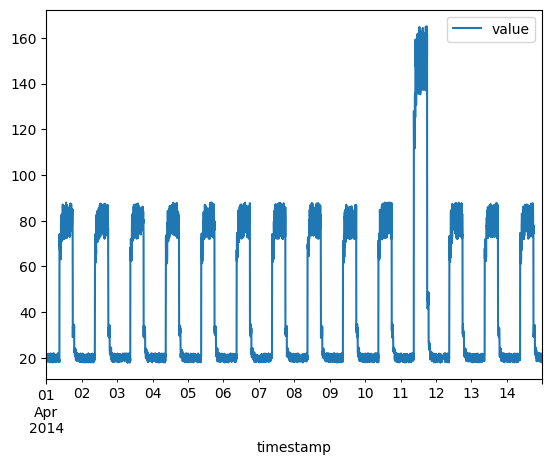

In [4]:
data.plot()

In [5]:
data.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [6]:
data.isna().mean()

value    0.0
dtype: float64

## Stationarity

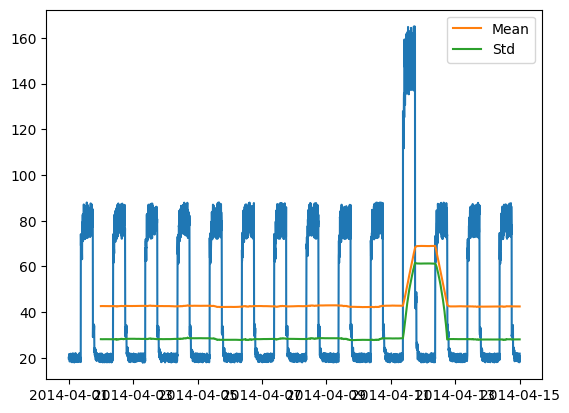

In [8]:
plt.plot(data)
plt.plot(data.rolling(window=288).mean().dropna(), label="Mean")
plt.plot(data.rolling(window=288).std().dropna(), label="Std")
plt.legend()

In [9]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = statsmodels.tsa.stattools.adfuller(data, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.908387e+00
p-value                        2.674749e-07
#Lags Used                     1.700000e+01
Number of Observations Used    4.014000e+03
Critical Value (1%)           -3.431980e+00
Critical Value (5%)           -2.862260e+00
Critical Value (10%)          -2.567153e+00
dtype: float64


To test stationarity, we will use Augmented Dickey Fuller Test :
 - Null Hypothesis : It assumes that the time series is non-stationary.
 - Alternate Hypothesis : If the null hypothesis is rejected, then the time series is stationary.

For a Time series to be stationary, its ADCF test should have:

 - p-value to be low < 0.05 (according to the null hypothesis)
 - The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
 - Test Statistic < Critical Value (5%) 

From the above ADCF test result, we see that p-value(at max can be 1.0) is very small. Also, Test Statistic < Critical Value. Hence, we can safely say that our Time Series is stationary

In [10]:
dec = seasonal_decompose(data['value'], period=288)

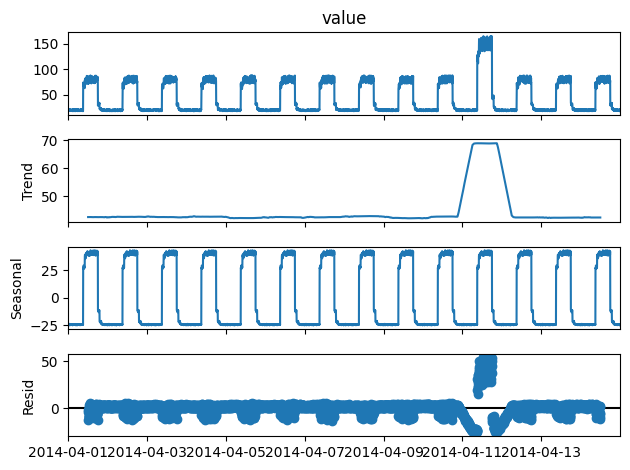

In [11]:
dec.plot()
plt.show()

## Daily profile

In [12]:
data["weekday"] = data.index.weekday
data["hour"] = data.index.hour

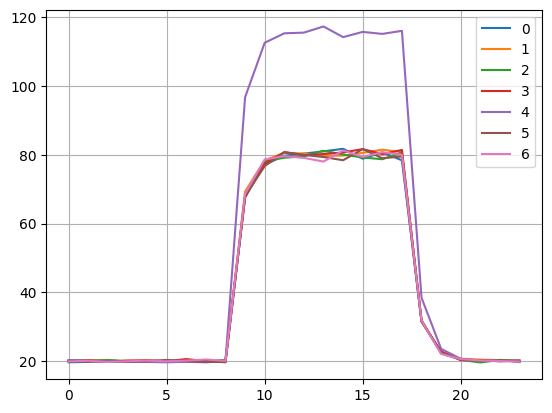

In [14]:
# Daily profile resampled to 1 hour
for day in range(7):
    plt.plot(data.where(data["weekday"]==day).groupby("hour").mean()["value"].dropna().values, label=day)
plt.legend()
plt.grid()

## Detect outliers

### MAD: Median Absolute Deviation

The Median Absolute Deviation (MAD) is a statistical measure that quantifies the dispersion or spread of a dataset by calculating the average absolute difference between each data point and the median of the dataset.

#### Calculation Steps:

1. **Calculate the Median:** Determine the median of the dataset, which is the middle value when the data points are ordered.

   $$ Median = Middle value of the ordered dataset $$

2. **Calculate the Absolute Deviation for Each Data Point:** Find the absolute difference between each data point and the median.

   $$ AbsoluteDeviation_i = |x_i - Median| $$

3. **Calculate the Median Absolute Deviation (MAD):** Find the median of these absolute deviations.

   $$ MAD = {Median(|x_i - Median|)} $$

The MAD provides a robust measure of the spread of data, as it is less sensitive to extreme values than some other dispersion measures like the standard deviation. It is commonly used in statistics and data analysis to assess the variability of a dataset and is particularly useful when dealing with skewed or heavy-tailed distributions.


In [15]:
data.drop(["hour", "weekday"], axis=1, inplace=True, errors='ignore')

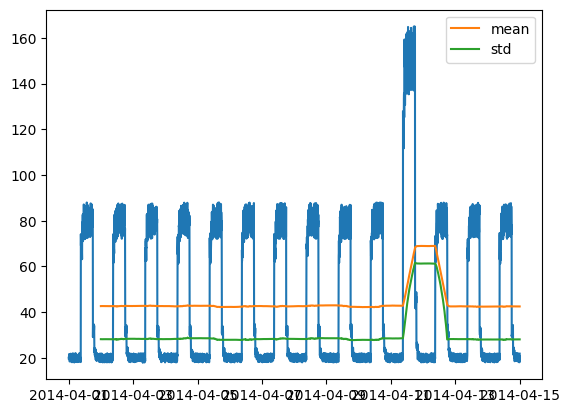

In [17]:
plt.plot(data)
plt.plot(data.rolling(window=288).mean().dropna(), label="mean")
plt.plot(data.rolling(window=288).std().dropna(), label="std")
plt.legend()

In [20]:
window = 288
med = np.median(data.values)
mad = np.array([np.median(abs(data.values[abs(idx - window // 2): idx + window // 2] - med)) for idx in range(len(data))])

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


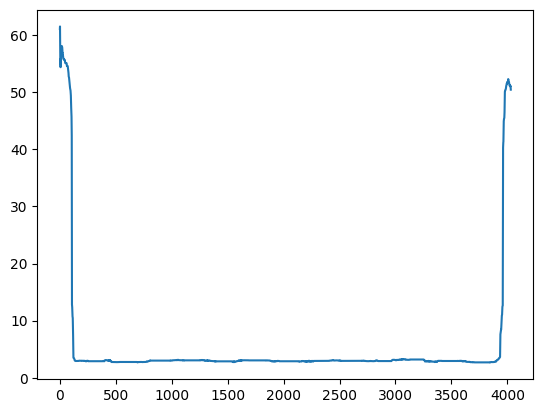

In [21]:
plt.plot(mad)

In [22]:
tolerence = 25
mask = abs(data.values.T[0] - med) > mad * tolerence

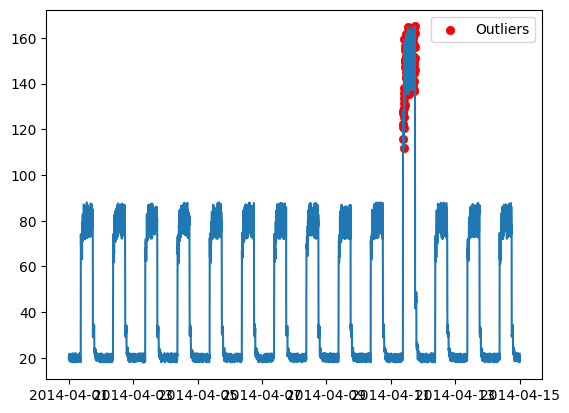

In [33]:
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", lw=.5, label="Outliers")
plt.legend()

### Clustering : dbscan

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is a clustering algorithm that excels in identifying clusters of arbitrary shapes in spatial data. Unlike traditional clustering algorithms like k-means, DBSCAN does not assume that clusters have a spherical shape or that they are equally sized. Instead, DBSCAN groups together data points that are close to each other in terms of a density measure.

#### Key Concepts:

- **Density-Based Clustering:** DBSCAN identifies clusters based on the density of data points. It defines clusters as dense regions separated by sparser areas.

- **Core Points, Border Points, and Noise:** The algorithm categorizes data points into three types:
  - **Core Points:** Points that have a specified minimum number of neighbors within a defined radius.
  - **Border Points:** Points within the radius of a core point but with fewer neighbors than required.
  - **Noise Points:** Points that are neither core nor border points.

#### Algorithm Steps:

1. Choose a point in the dataset.
2. If it has the minimum number of neighbors within the specified radius, it becomes a core point, and a cluster is formed.
3. Expand the cluster by adding neighboring core points.
4. Repeat the process until no more points can be added to the cluster.
5. Move to an unvisited point and repeat the process until all points are visited.

#### Advantages:

- Handles clusters of arbitrary shapes.
- Does not require specifying the number of clusters beforehand.
- Can identify outliers as noise points.

#### Parameters:

- **Epsilon (eps):** The radius within which the algorithm searches for neighboring points.
- **MinPts:** The minimum number of points required to form a dense region (core point).


In [24]:
from  sklearn.cluster import DBSCAN

In [25]:
def euclidean(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [26]:
med = np.median(data.value)
eps = np.median([euclidean(x, med) for x in data.value])
tolerance = 5

In [27]:
cluster = DBSCAN(eps=tolerance * eps, min_samples=int(len(data.value) * 0.1))

In [28]:
cluster.fit(data)
labels = cluster.labels_

In [29]:
print(f"Number of clusters = {len(set(labels) - set([-1]))}")

Number of clusters = 2


In [30]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([ 108, 2520, 1404]))

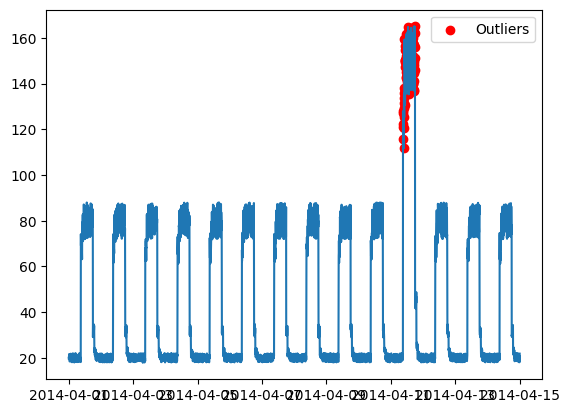

In [35]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", label="Outliers")
plt.legend()

### Clustering : k-means

**K-means** is a popular clustering algorithm used in unsupervised machine learning to partition a dataset into distinct, non-overlapping groups or clusters. The primary goal of K-means is to group similar data points together and assign them to the same cluster, with the aim of minimizing the within-cluster variance.

#### Key Concepts:

- **Objective:** K-means aims to divide a dataset into \(k\) clusters, where each cluster is represented by a centroid. The algorithm works iteratively to minimize the sum of squared distances between data points and their assigned cluster centroids.

#### Algorithm Steps:

1. **Initialization:** Randomly select \(k\) data points as initial centroids.
2. **Assignment:** Assign each data point to the nearest centroid, forming \(k\) clusters.
3. **Update Centroids:** Recalculate the centroids as the mean of the data points within each cluster.
4. **Repeat:** Repeat steps 2 and 3 until convergence (when centroids no longer change significantly).

#### Advantages:

- Simple and computationally efficient.
- Scales well to large datasets.
- Works well when clusters are spherical and equally sized.

#### Challenges:

- Sensitive to initial centroid selection.
- Assumes clusters are spherical and equally sized.
- May converge to local optima.

#### Use Cases:

- Customer segmentation.
- Image compression.
- Anomaly detection.

#### Parameters:

- \(k\): The number of clusters to form.

K-means is widely used for its simplicity and efficiency, especially in scenarios where the underlying clusters have similar sizes and shapes. However, it may not perform well when clusters have irregular shapes or varying sizes, as it assumes a circular geometry for clusters.


In [36]:
from sklearn.cluster import KMeans

In [37]:
kmeans_instance = [KMeans(n_clusters=i).fit(data) for i in range(1, 8)]

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/

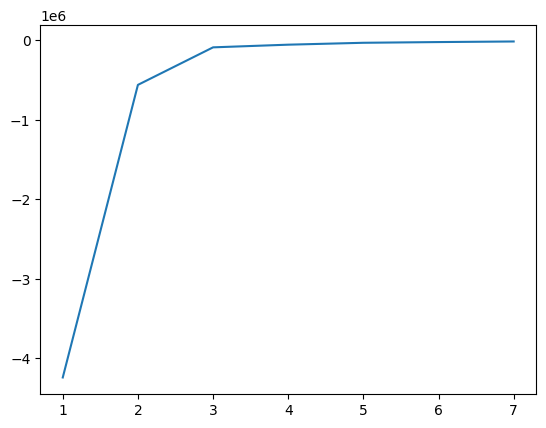

In [38]:
plt.plot(range(1, 8), [kmeans_instance[i].score(data) for i in range(7)])

##### detect outlier as a stand alone class

In [39]:
kmeans_instance = KMeans(n_clusters=2).fit(data)

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
kmeans_instance.score(data)

-564921.3423464587

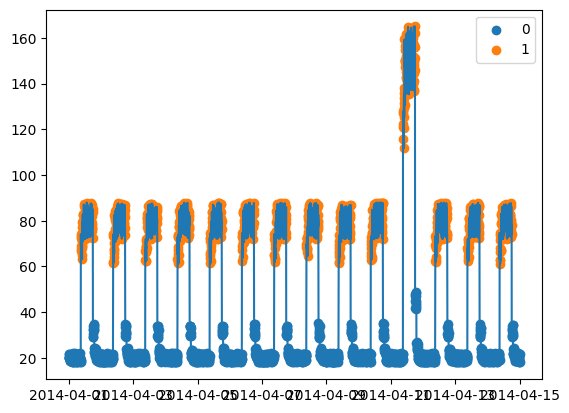

In [42]:
plt.plot(data)
for label in set(kmeans_instance.labels_):
    plt.scatter(data.index[kmeans_instance.labels_==label], data.value[kmeans_instance.labels_==label], label=label)
plt.legend()

In [43]:
kmeans_instance.cluster_centers_

array([[21.10842593],
       [83.47063454]])

##### detect outlier as points far from built clusters

In [44]:
min_distance = kmeans_instance.transform(data).min(axis=1)

In [47]:
window = 288
med = np.median(data.values)
mad = np.array([np.median(abs(min_distance[max(0, idx - window // 2): idx + window // 2] - med)) for idx in range(len(min_distance))])

In [48]:
tolerence = 4
mask = abs(data.values.T[0] - med) > mad * tolerence

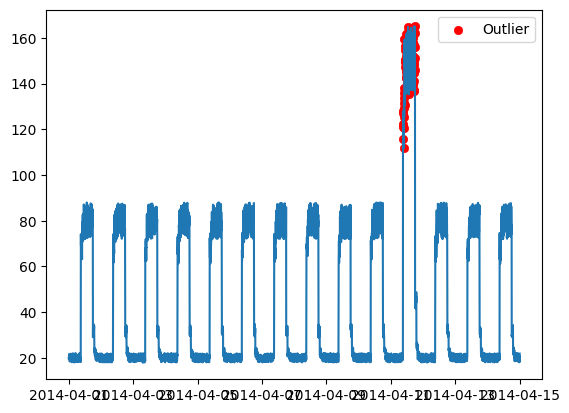

In [49]:
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", lw=.5, label="Outlier")
plt.legend()

### Bonus: test of 2 other algorithms

#### Unsupervised : OneClassSVM

In [53]:
one_class = OneClassSVM()
one_class.fit(data)

OneClassSVM()

In [54]:
labels = one_class.predict(data)

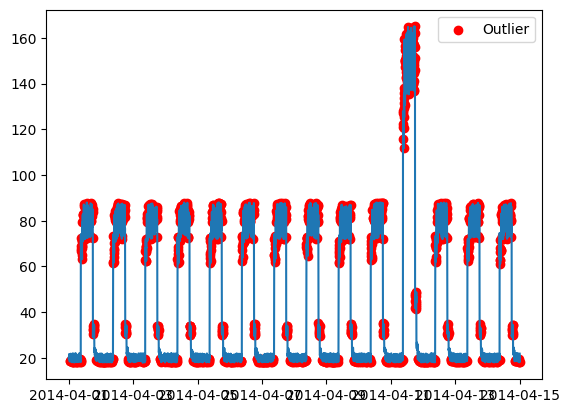

In [58]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", label="Outlier")
plt.legend()

#### IsolationForest

In [60]:
iso_forest = IsolationForest(n_estimators=100)
iso_forest.fit(data)

IsolationForest()

In [61]:
labels = iso_forest.predict(data)

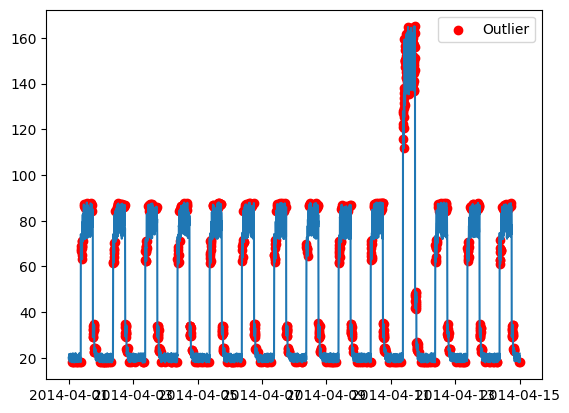

In [62]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", label="Outlier")
plt.legend()